In [1]:
import yfinance as yf
import seaborn as sns
import pandas  as pd
import numpy as np
import pandas_market_calendars as mcal
import pytz

import datetime
import plotly.graph_objects as go
import plotly.express as px
from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Diffusion_process

import scipy.stats as ss
from scipy.integrate import quad
from typing import List, Optional
from scipy.stats import lognorm
from scipy.stats import norm
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

from utils.gbm import GBMAnalyzer
from utils.dataFetcher import OptionsDataFetcher as odf

In [2]:
fetcher = odf('TSLA')
stock_data = fetcher.fetch_stock_data("2022-04-18", "2025-05-18")
opts_data = fetcher.fetch_options_chain()
opts_data_p = fetcher.fetch_options_chain(puts_only = True)
opts_data_c = fetcher.fetch_options_chain(calls_only = True)
# fetcher.save(stock_data, opts_data, path="retrivedData", save_stock=True, save_options=True)

In [29]:
nyse = mcal.get_calendar('NYSE')
ny_tz = pytz.timezone('America/New_York')

def trading_day_after_n_days(start_date, n_days):
    """
    Returns the f irst NYSE trading day strictly after (or before, if n_days < 0)
    the date shifted by n_days. Always returns a trading day different from the shifted date.
    """
    # Shift the date by n_days
    target_date = start_date + pd.Timedelta(days=n_days)
    target_date = target_date.normalize()

    # Define search window and filtering logic
    if n_days >= 0:
        search_start = target_date + pd.Timedelta(days=1)
        search_end = target_date + pd.Timedelta(days=15)
    else:
        search_start = target_date - pd.Timedelta(days=15)
        search_end = target_date - pd.Timedelta(days=1)

    # Get valid trading days in the range
    schedule = nyse.valid_days(start_date=search_start, end_date=search_end)

    if not schedule.empty:
        selected_date = schedule[0] if n_days >= 0 else schedule[-1]
        return selected_date.tz_convert(ny_tz)
    else:
        raise ValueError(f"No trading day found in the expected window around {target_date}")

def trading_day_after_n_days(start_date, n_days):
    """
    Returns the first NYSE trading day on or after (or on or before, if n_days < 0)
    the date shifted by n_days. Always returns a trading day >= or <= the shifted date.
    """
    # Shift the date by n_days
    target_date = (start_date + pd.Timedelta(days=n_days)).normalize()

    # Define search window (inclusive)
    if n_days >= 0:
        search_start = target_date
        search_end = target_date + pd.Timedelta(days=15)
    else:
        search_start = target_date - pd.Timedelta(days=15)
        search_end = target_date

    # Get valid trading days in the range
    schedule = nyse.valid_days(start_date=search_start, end_date=search_end)

    if not schedule.empty:
        selected_date = schedule[0] if n_days >= 0 else schedule[-1]
        return selected_date.tz_convert(ny_tz)
    else:
        raise ValueError(f"No trading day found in the expected window around {target_date}")



In [4]:
def mu_sig_annual(prices, days = 365):

    # Step 1: Calculate daily log returns
    log_returns = np.log(prices[1:] / prices[:-1])
    
    # Step 2: Calculate daily mean return and daily volatility
    mu_daily = np.mean(log_returns)
    sigma_daily = np.std(log_returns)
    
    # Step 3: Annualize drift and volatility assuming 252 trading days
    mu = mu_daily * days
    sigma = sigma_daily * np.sqrt(days)
    return mu, sigma

def drift_term(mu, sigma, t):
    return (mu - 0.5 * sigma**2) * t

def St(S0, mu, sigma, t):
    Z = np.random.normal()  # standard normal random variable
    return S0 * np.exp(drift_term(mu, sigma, t) + sigma * Z * np.sqrt(t))

def predict_prices(prices, t):
    mu, sigma = mu_sig_annual(prices)
    predicted = []
    for S0 in prices:
        predicted_price = St(S0, mu, sigma, t)
        predicted.append(predicted_price)
    return predicted

In [79]:
end_date_train = stock_data.index[300]
t = 1
start_date_train = trading_day_after_n_days(end_date_train, -t*365)
start_date_test = trading_day_after_n_days(end_date_train,0)
end_date_test = trading_day_after_n_days(start_date_test,t*365)

In [80]:
train_data = stock_data.loc[start_date_train:end_date_train]
test_data = stock_data.loc[start_date_test:end_date_test]

In [81]:
initial_dates = np.array(train_data.index)
pred_dates = [trading_day_after_n_days(date, t*365) for date in initial_dates]

In [82]:
def is_weekend(date):
    return 1 if date.weekday() >= 5 else 0  # Saturday = 5, Sunday = 6

In [83]:
train_data = train_data.assign(pred_date = pred_dates, predictions = predict_prices(train_data['Close'], t))

In [84]:
train_data = train_data.assign(isWeekend = [is_weekend(date) for date in train_data['pred_date']])
data = train_data[['Close', 'pred_date', 'predictions', 'isWeekend']]

In [132]:
prices = np.array(train_data['Close'])

simulations = []
num_simulations = 10000
for _ in range(num_simulations):
    predicted = predict_prices(prices, t)
    simulations.append(predicted)

In [135]:
simulations = np.array(simulations)

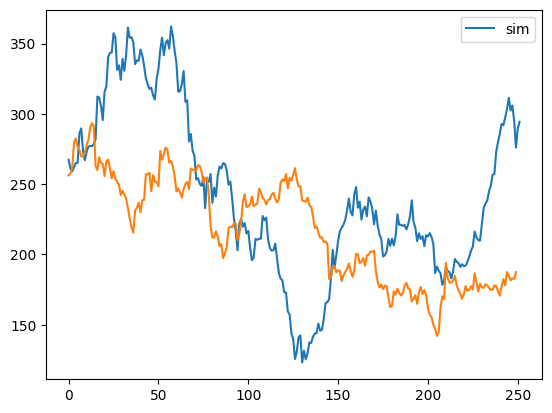

In [137]:
plt.plot(simulations.mean(axis = 0), label = 'sim')
plt.plot(test_data.reset_index()['Close'])
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (251,) and (253,)

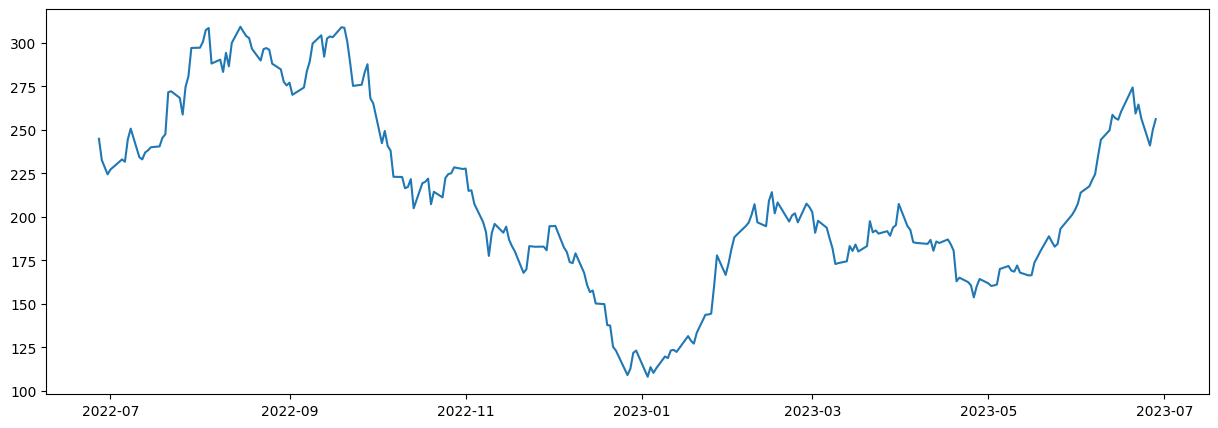

In [8]:
prices = np.array(train_data['Close'])

simulations = []
num_simulations = 10000
for _ in range(num_simulations):
    predicted = predict_prices(prices, t)
    simulations.append(predicted)
    
plt.figure(figsize=(15, 5))
simulations = np.array(simulations)
mean_pred = np.mean(simulations, axis=0)
k = (test_data['Close'].iloc[0] - mean_pred[0])
mean_pred += k  
median_pred = np.median(simulations, axis=0)
median_pred += k  
std_pred = np.std(simulations, axis=0)
n_std = 1
plt.plot(train_data.index, train_data['Close'], label = 'train_data')
plt.plot(test_data.index, prices, label='Actual/test_data', color = 'yellow')
plt.plot(test_data.index, mean_pred, label='Mean Prediction', color='red', alpha = 0.5)
plt.plot(test_data.index, median_pred, label='Median Prediction', color='green', alpha = 0.7)
plt.fill_between(test_data.index,
                 mean_pred - n_std*std_pred,
                 mean_pred + n_std*std_pred,
                 color='blue', alpha=0.3, label=f'±{n_std} std_dev')

plt.axhline(y=np.mean(prices), color='r', linestyle='--', label='Actual Mean')
plt.axhline(y=np.mean(mean_pred), color='g', linestyle='--', label='Predicted Mean')
plt.legend()
plt.title(f'Stock Price Prediction Simulation ({num_simulations} runs)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.savefig("better_result.png", bbox_inches='tight')
plt.show()
#NOT A CONTINUOUS TIME SERIES WHICH MEANS MAKES A VECTOR OF POSSIBLE VALUES WHERE PRICES ARE INDEPENDENT OF EACH OTHER

In [ ]:
plt.figure(figsize=(10, 6))

for i in range(len(simulations)):
    series = pd.Series(simulations[i])
    series.hist(bins=30, alpha=0.05, edgecolor='none', color='gray')
    plt.axvline(series.mean(), color='red', linestyle='--', alpha=0.1)
    plt.axvline(series.median(), color='green', linestyle='-', alpha=0.1)
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_data.index, y=prices, mode='lines', name='Actual', line=dict(color='black', width=2)))
fig.add_trace(go.Scatter(x=test_data.index, y=mean_pred, mode='lines', name='Mean Prediction', line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=test_data.index, y=median_pred, mode='lines', name='Median Prediction', line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(
    x=np.concatenate([test_data.index, test_data.index[::-1]]),
    y=np.concatenate([mean_pred + std_pred, (mean_pred - std_pred)[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 0, 255, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='±1 std dev'
))
fig.add_trace(go.Scatter(x=test_data.index, y=[np.mean(prices)]*len(prices), mode='lines',
                         name='Actual Mean', line=dict(dash='dash', color='red')))
fig.add_trace(go.Scatter(x=test_data.index, y=[np.mean(mean_pred)]*len(mean_pred), mode='lines',
                         name='Predicted Mean', line=dict(dash='dash', color='green')))

fig.update_layout(
    title='Stock Price Prediction Simulation (1000 runs)',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()